In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib as mpl
import os
from scipy.optimize import curve_fit as cf
from scipy.signal import find_peaks as fp
from scipy.signal import peak_widths
from scipy.interpolate import interp1d
from scipy.constants import c,h,e

In [3]:
mpl.rcParams['lines.linewidth'] = 2
mpl.rcParams['lines.markersize'] = 4
mpl.rcParams['figure.autolayout'] = True
mpl.rcParams['font.size'] = 15
mpl.rcParams['errorbar.capsize'] = 3
mpl.rcParams['lines.markeredgewidth'] = 1
mpl.rcParams['axes.axisbelow'] = True

In [4]:
from math import floor
import scipy.stats as stats

dcmls = lambda x : -int(floor(np.log10(abs(x))))

round_error = lambda value,rounder : np.round(value,dcmls(rounder))

def chi2(y,y_err,x,func,popt):
    y_ajuste = func(x,*popt)
    chi_cuadrado = np.sum(((y-y_ajuste)/y_err)**2)
    return chi_cuadrado

def pvalue(y,y_err,x,func,popt):
    chi_cuadrado = chi2(y,y_err,x,func,popt)
    puntos = len(y)
    params = len(popt)
    grados_lib = puntos - params - 1
    pvalor = stats.chi2.sf(chi_cuadrado,grados_lib)
    return pvalor

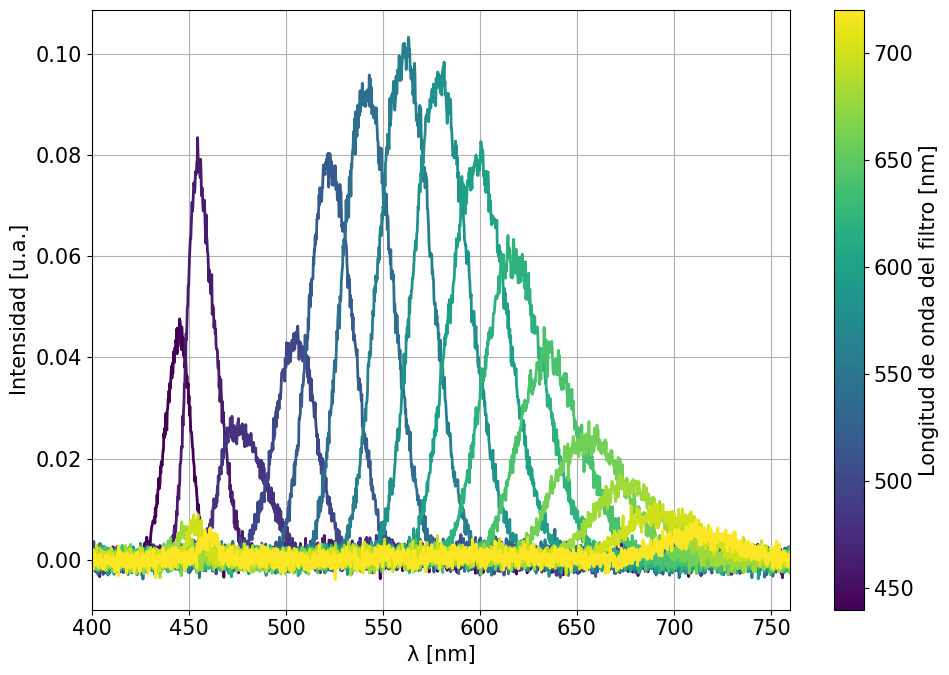

In [5]:
lambdas = np.arange(440,740,20)

def index_to_xdata(xdata,indices):
    ind = np.arange(len(xdata))
    f = interp1d(ind,xdata)
    return f(indices)

norm = mpl.colors.Normalize(vmin=lambdas.min(), vmax=lambdas.max())
cmap = mpl.cm.viridis

fig, ax = plt.subplots(figsize=(10, 7))

central_lambdas = []
err_lambdas = []
lambda_i = []
lambda_d = []
for i in range(len(lambdas)):
    long = lambdas[i]
    df = pd.read_csv(f'espectros filtrados/{int(lambdas[i])}.csv', header=None, names=['long', 'I'])
    color = cmap(norm(lambdas[i]))
    plt.plot(df.long, df.I,color=color)#, label=f'{lambdas[i]} nm')

    
    pk = fp(df.I,height=0.9*np.max(df.I),distance=200)[0]
    widths, width_heights, left_ips, right_ips = peak_widths(df.I,pk,rel_height=1-1/2)
    widths = index_to_xdata(df.long,widths)
    left_ips = index_to_xdata(df.long,left_ips)
    right_ips = index_to_xdata(df.long,right_ips)
    
    long_central = df.long[pk[0]]
    err_long_central = (right_ips - left_ips)[0]/2
    
    #plt.scatter(long_central,df.I[pk],c='crimson',zorder=2)
    #plt.hlines(width_heights,left_ips,right_ips,color=color,ls='--')
    central_lambdas.append(long_central)
    err_lambdas.append(err_long_central)
    lambda_i.append(left_ips[0])
    lambda_d.append(right_ips[0])

central_lambdas = np.array(central_lambdas)*1e-9
err_lambdas = np.array(err_lambdas)*1e-9
lambda_i = np.array(lambda_i)*1e-9
lambda_d = np.array(lambda_d)*1e-9
nus = c/central_lambdas
err_nus = c/central_lambdas**2*err_lambdas

sm = plt.cm.ScalarMappable(cmap=cmap, norm=norm)
sm.set_array([])
cbar = cbar = fig.colorbar(sm, ax=ax, orientation="vertical")
cbar.set_label('Longitud de onda del filtro [nm]')

plt.xlim(400,760)
plt.grid()
plt.xlabel('\u03BB [nm]')
plt.ylabel('Intensidad [u.a.]')
plt.tight_layout()
plt.savefig('plots/espectros.png')

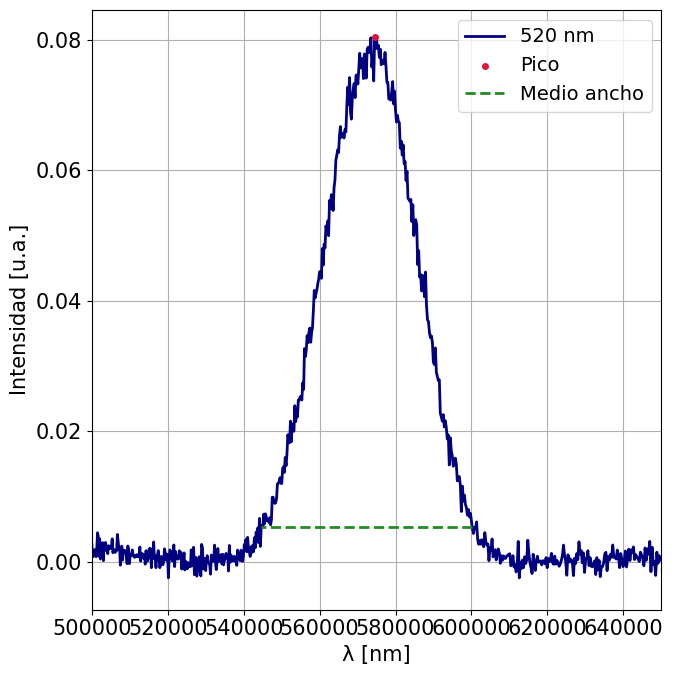

In [194]:
fig, ax = plt.subplots(figsize=(7, 7))

long = 520
df = pd.read_csv(f'espectros filtrados/{long}.csv', header=None, names=['long', 'I'])
color = cmap(norm(lambdas[i]))
plt.plot(c/df.long, df.I,color='navy',label=f'{long} nm')
    
pk = fp(df.I,height=0.9*np.max(df.I),distance=200)[0]
widths, width_heights, left_ips, right_ips = peak_widths(df.I,pk,rel_height=1-1/10)
widths = index_to_xdata(c/df.long,widths)
left_ips = index_to_xdata(c/df.long,left_ips)
right_ips = index_to_xdata(c/df.long,right_ips)
    
plt.scatter(c/df.long[pk],df.I[pk],c='crimson',zorder=2,label='Pico')
plt.hlines(width_heights,left_ips,right_ips,color='forestgreen',ls='--',label='Medio ancho')

plt.xlim(0.5e6,0.65e6)
#plt.xlim(long-60,long+60)
plt.grid()
plt.xlabel('\u03BB [nm]')
plt.ylabel('Intensidad [u.a.]')
plt.legend(fontsize=14)
plt.tight_layout()
plt.savefig('plots/campana.png')

In [7]:
from statsmodels.nonparametric.smoothers_lowess import lowess
from scipy.signal import savgol_filter as savgol

In [6]:
read_df = lambda df : pd.read_csv(f'clase2/{df}.csv',header=0,names=['_','V_e','I','fase','x','y']).iloc[:,1:]

In [9]:
derivar = lambda y : np.gradient(y,df.V_e)
filtrar = lambda y : lowess(y,range(len(y)),frac=0.13)[:,1]
norm_array = lambda y : y/np.max(y)

-0.303030303030303 0.5454545454545454


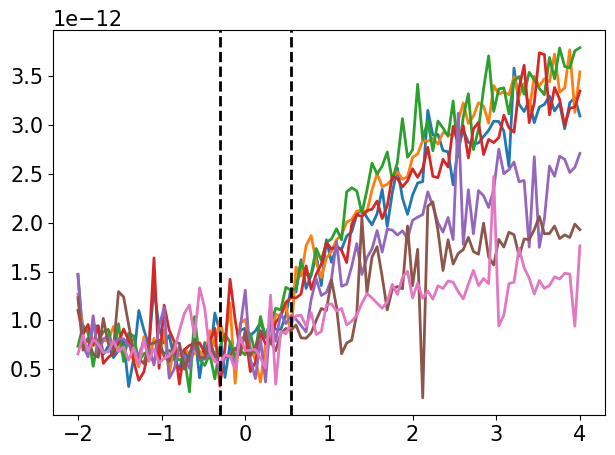

In [88]:
for long in lambdas[2:9]:
    df = read_df(f'segundo intento largo/{long}')
    plt.plot(df.V_e,df.I)
#    plt.ylim(-1e-12,1e-12)
#    plt.show()
plt.axvline(df.V_e[28],c='k',ls='--')
plt.axvline(df.V_e[42],c='k',ls='--')
print(df.V_e[28],df.V_e[42])


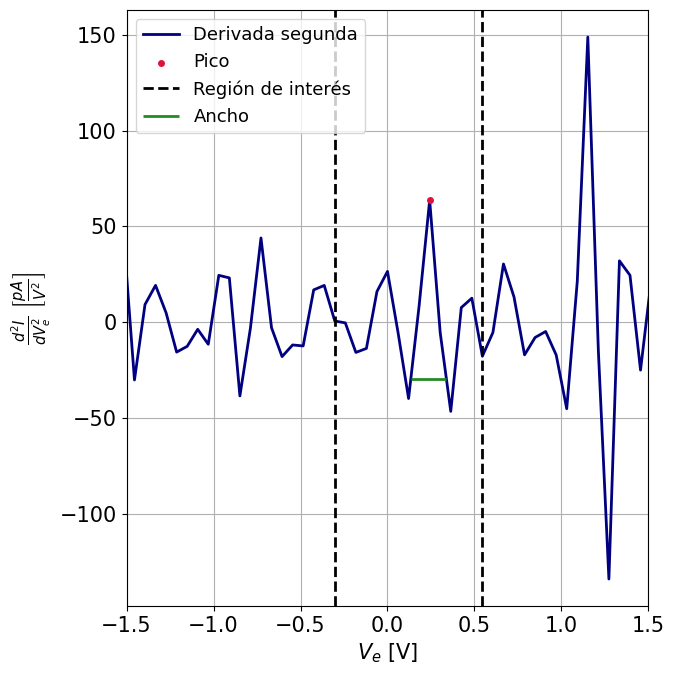

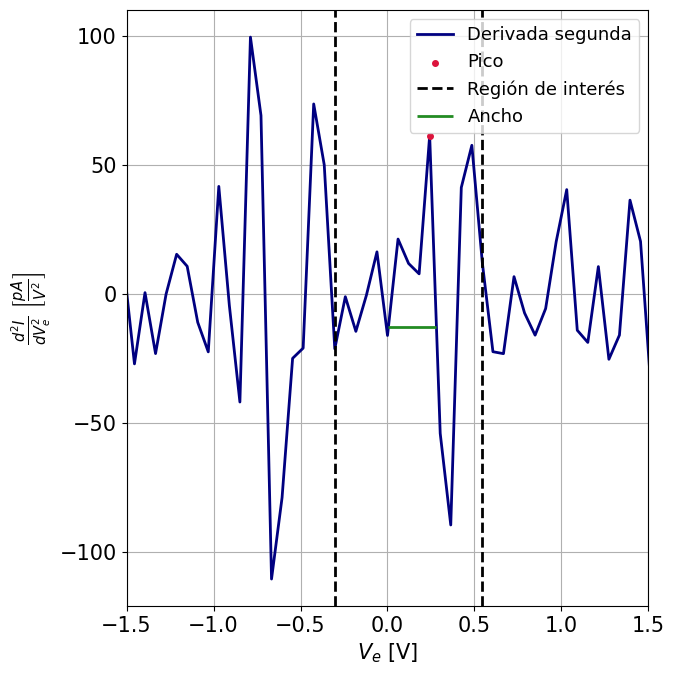

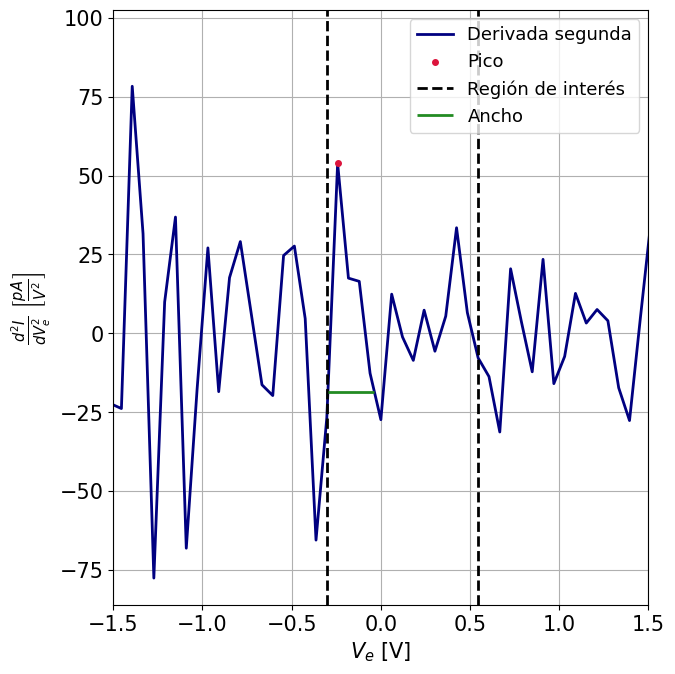

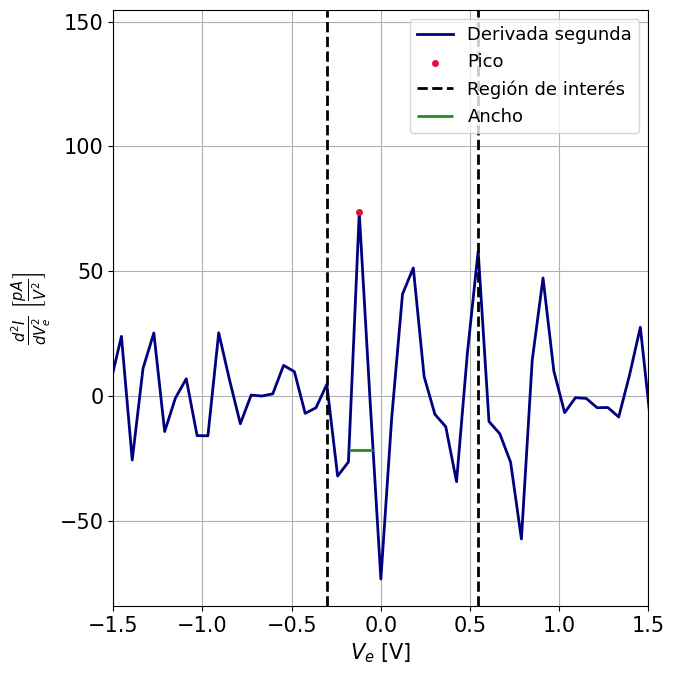

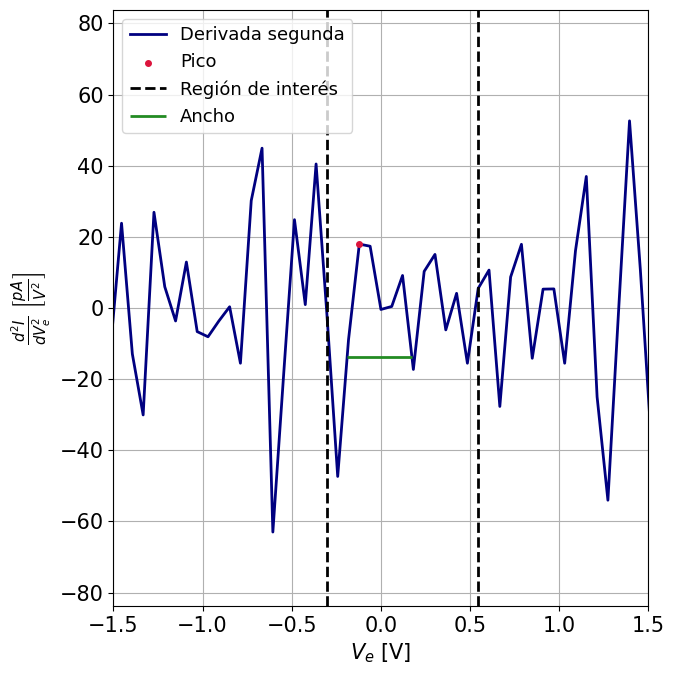

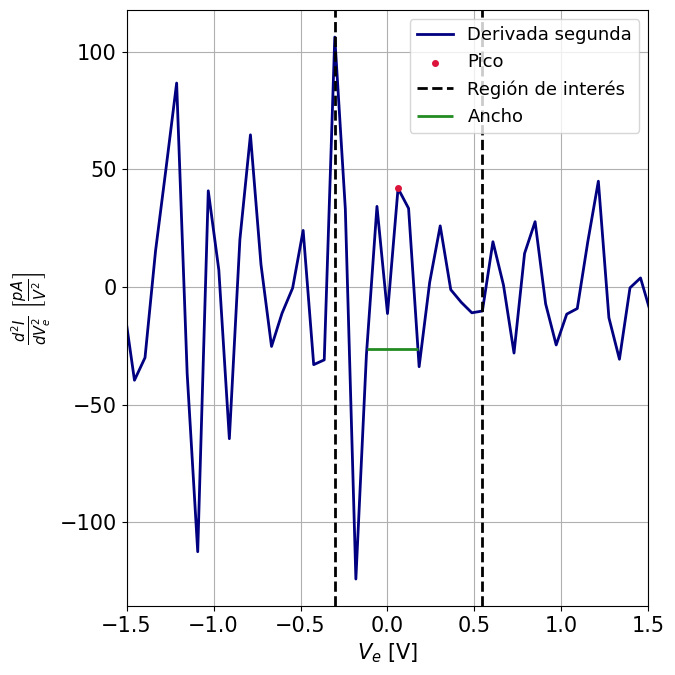

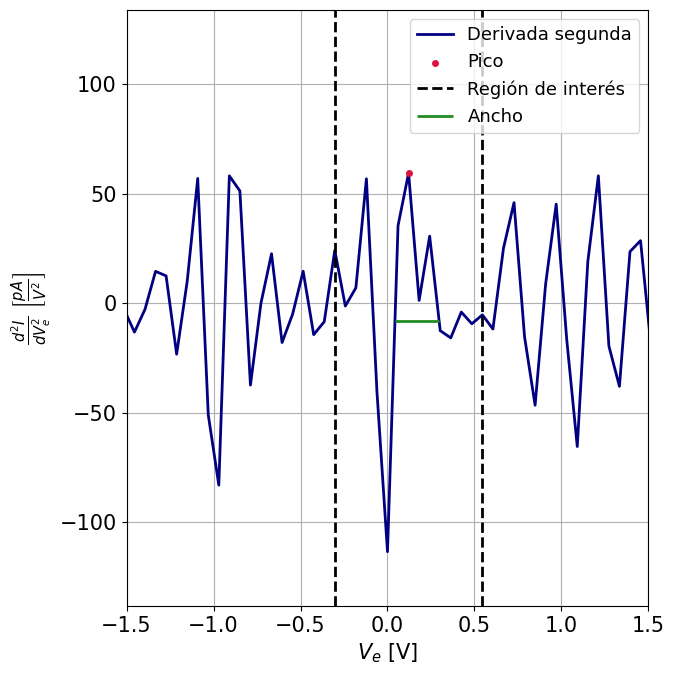

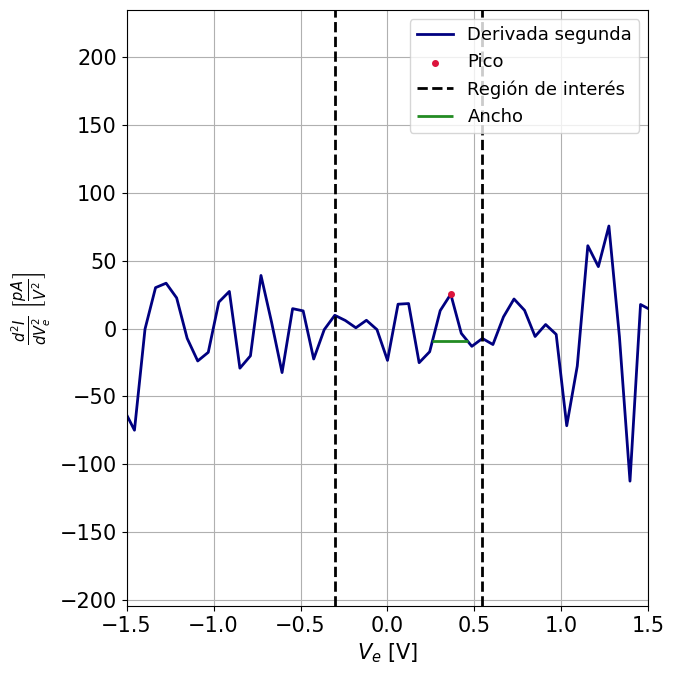

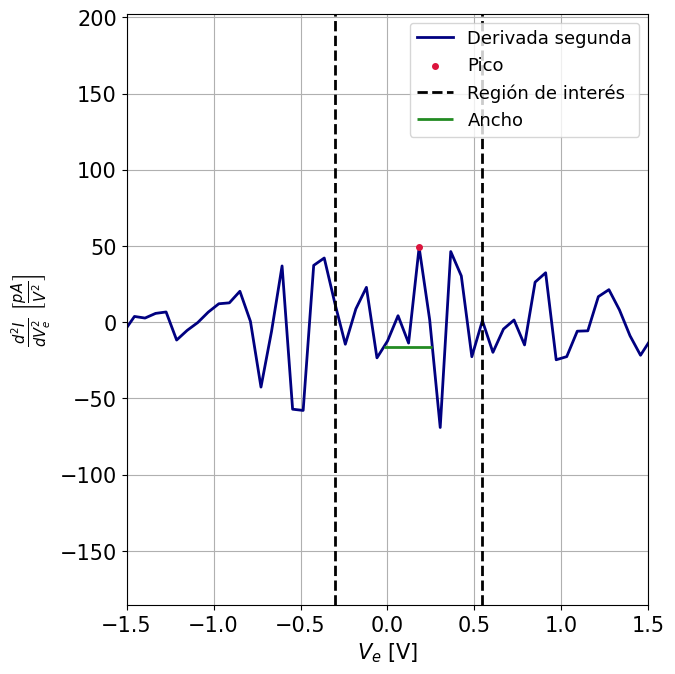

In [7]:
def find_V0(df,save=False):
    derivar = lambda y : np.gradient(y,df.V_e)
#    filtrar = lambda y : lowess(y,range(len(y)),frac=0.2)[:,1]#savgol(y,window_length=5,polyorder=2) #lowess(y,range(len(y)),frac=0.09)[:,1]
#    filtered_I = filtrar(df.I)
    derivada2 = derivar(derivar(df.I))
#    derivada2 = savgol(df.I,window_length=15,polyorder=3,deriv=2,delta=np.mean(np.diff(df.V_e)))
#    derivada2 = filtrar(derivada2)
    #derivada2 = derivar(derivar(filtered_I))
    #derivada2 = savgol(df.I,window_length=15,polyorder=3,deriv=2,delta=np.mean(np.diff(df.V_e)))

    idx_s = 28
    idx_e = 42
    pk = fp(derivada2[idx_s:idx_e],height=0,distance=10)[0][0]+idx_s
    widths, width_heights, left_ips, right_ips = peak_widths(derivada2[idx_s:idx_e],np.array([pk])-idx_s,rel_height=1-1/10)
    widths = index_to_xdata(df.V_e[idx_s:idx_e],widths)
    left_ips = index_to_xdata(df.V_e[idx_s:idx_e],left_ips)
    right_ips = index_to_xdata(df.V_e[idx_s:idx_e],right_ips)
    
    V0 = df.V_e[pk]
    err_V0 = (right_ips - left_ips)[0]/2

    plt.figure(figsize=(7,7))
    plt.plot(df.V_e,derivada2*1e12,c='navy',zorder=1,label='Derivada segunda')
    plt.scatter(V0,derivada2[pk]*1e12,c='crimson',zorder=2,label='Pico')
    plt.axvline(df.V_e[idx_s],c='k',ls='--',label='Región de interés')
    plt.axvline(df.V_e[idx_e],c='k',ls='--')
    plt.hlines(width_heights*1e12,left_ips,right_ips,color='forestgreen',label='Ancho')    

    plt.xlim(-1.5,1.5)
    plt.grid()
    plt.xlabel(r'$V_{e}$ [V]')
    plt.ylabel(r'$\frac{d^{2}I}{dV_{e}^{2}}$ $\left[\frac{pA}{V^{2}}\right]$')
    plt.legend(fontsize=13)
    plt.tight_layout()
    if save:
        plt.savefig('plots/derivada.png')
    plt.show()
    plt.close()
    return V0,err_V0

V0s = []
err_V0s = []
for long in lambdas[:9]:
    df = read_df(f'segundo intento largo/{long}')
    if long == 500:
        V0,err_V0 = find_V0(df,save=True)
    else:
        V0,err_V0 = find_V0(df)
    V0s.append(V0)
    err_V0s.append(err_V0)
V0s = np.array(V0s)
err_V0s = np.array(err_V0s)

2.5316628524727047
h_der = (4.0 ± 1.0) 1e-15 eV·s = (1.1 ± 0.2) h


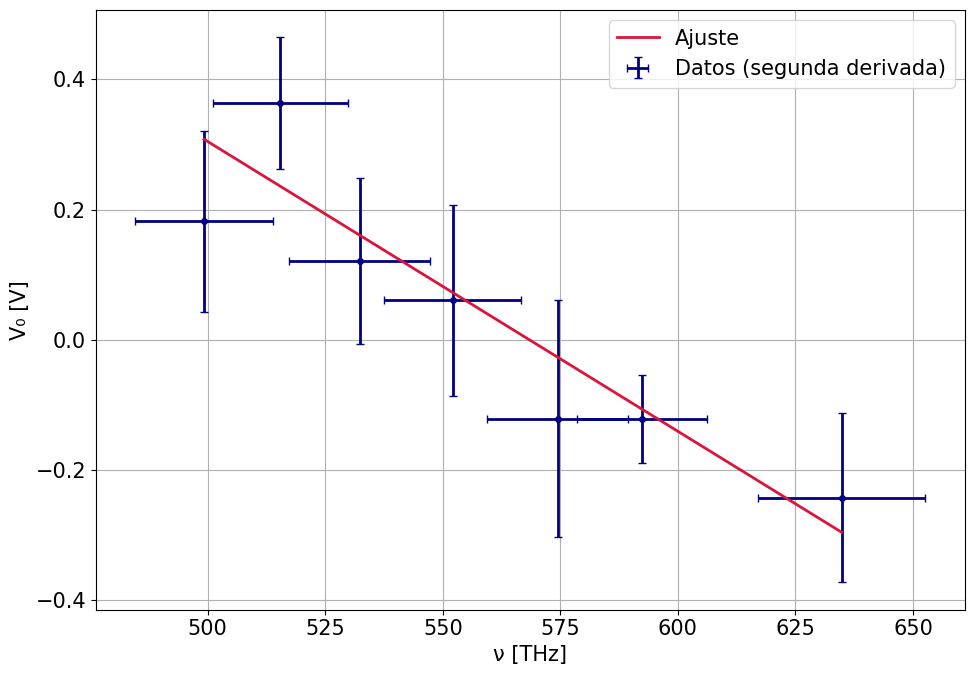

In [8]:
plt.subplots(figsize=(10, 7))
lineal = lambda x,a,b : a*x+b
nus_res = nus[2:9]
err_nus_res = err_nus[2:9]
V0s_res = V0s[2:]
err_V0s_res = err_V0s[2:]

pars,cov = cf(lineal,nus_res,V0s_res,sigma=err_V0s_res,absolute_sigma=True)
m = -pars[0]
err_m = np.sqrt(cov[0,0])

x_adj = np.linspace(min(nus_res),max(nus_res),100)
y_adj = lineal(x_adj,*pars)
print(pars[1])
#print(h/e)
#print('pendiente =',np.round(-pars[0]/(h/e),2),'h')
print(f'h_der = ({round_error(m*1e15,err_m*1e15)} \u00B1 {round_error(err_m*1e15,err_m*1e15)}) 1e-15 eV\u00B7s = ({round_error(m*e/h,err_m*e/h)} \u00B1 {round_error(err_m*e/h,err_m*e/h)}) h')

plt.scatter(nus_res*1e-12,V0s_res,c='navy',zorder=2)
plt.plot(x_adj*1e-12,y_adj,c='crimson',zorder=3,label='Ajuste')
plt.errorbar(nus_res*1e-12,V0s_res,yerr=err_V0s_res,xerr=err_nus_res*1e-12,fmt='None',ecolor='navy',zorder=1,label='Datos (segunda derivada)')
plt.grid()
#plt.xlim(480,655)
plt.xlabel('\u03BD [THz]')
plt.ylabel('V\u2080 [V]')
plt.legend()
plt.tight_layout()
plt.savefig('plots/lineal derivadas.png')

0.3636363636363637
0.26845529270583657


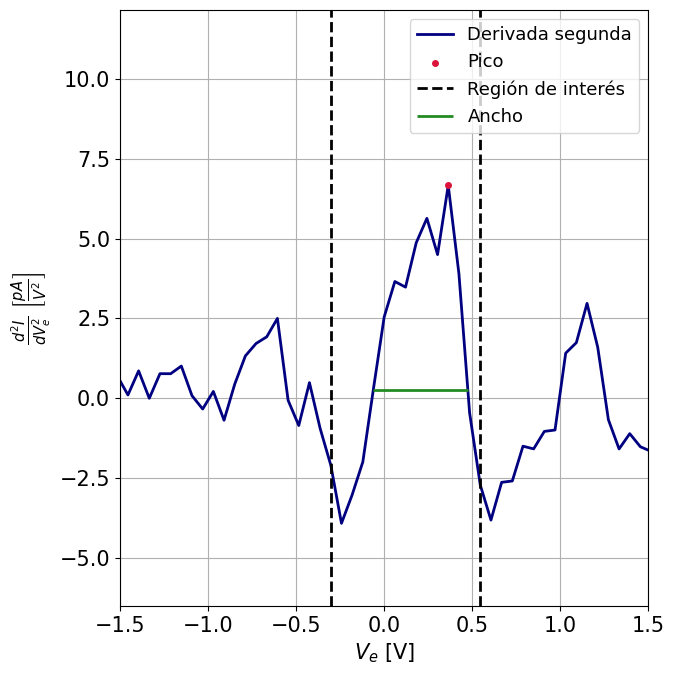

In [131]:
df = read_df('segundo intento largo/500')
derivar = lambda y : np.gradient(y,df.V_e)
derivada2 = savgol(df.I,window_length=15,polyorder=3,deriv=2,delta=np.mean(np.diff(df.V_e)))

idx_s = 28
idx_e = 42
pk = fp(derivada2[idx_s:idx_e],height=0,distance=10)[0][0]+idx_s
widths, width_heights, left_ips, right_ips = peak_widths(derivada2[idx_s:idx_e],np.array([pk])-idx_s,rel_height=1-1/10)
widths = index_to_xdata(df.V_e[idx_s:idx_e],widths)
left_ips = index_to_xdata(df.V_e[idx_s:idx_e],left_ips)
right_ips = index_to_xdata(df.V_e[idx_s:idx_e],right_ips)
    
V0 = df.V_e[pk]
err_V0 = (right_ips - left_ips)[0]/2
print(V0)
print(err_V0)

plt.figure(figsize=(7,7))
plt.plot(df.V_e,derivada2*1e12,c='navy',zorder=1,label='Derivada segunda')
plt.scatter(V0,derivada2[pk]*1e12,c='crimson',zorder=2,label='Pico')
plt.axvline(df.V_e[idx_s],c='k',ls='--',label='Región de interés')
plt.axvline(df.V_e[idx_e],c='k',ls='--')
plt.hlines(width_heights*1e12,left_ips,right_ips,color='forestgreen',label='Ancho')    

plt.xlim(-1.5,1.5)
plt.grid()
plt.xlabel(r'$V_{e}$ [V]')
plt.ylabel(r'$\frac{d^{2}I}{dV_{e}^{2}}$ $\left[\frac{pA}{V^{2}}\right]$')
plt.legend(fontsize=13)
plt.tight_layout()
#plt.savefig('plots/derivada.png')
plt.show()
plt.close()

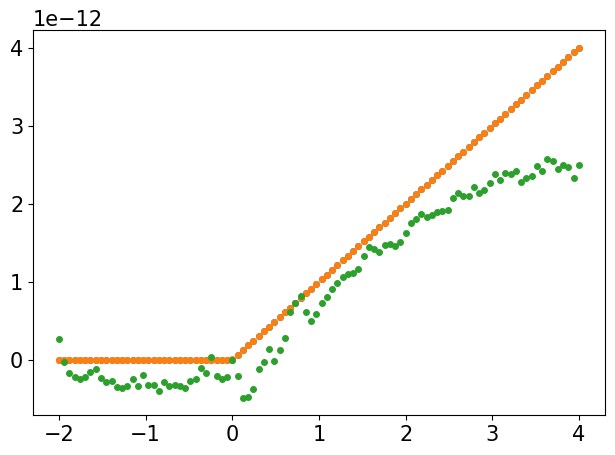

In [76]:
def partida(xs):
    y = []
    for x in xs:
        if x < 0:
            y.append(0)
        else:
            y.append(1e-12*(x))
    return np.array(y)

df = read_df('segundo intento largo/500')
filtrar = lambda y : lowess(y,range(len(y)),frac=0.5)[:,1]
filtrar = lambda y : savgol(y,window_length=5,polyorder=3)
x = np.linspace(min(df.V_e),max(df.V_e),len(df))
plt.scatter(x,partida(x))
plt.scatter(x,filtrar(partida(x)))
plt.scatter(df.V_e,filtrar(df.I)-1e-12)

0.42249576474181777
0.48437164053374937


(-1.5, 1.5)

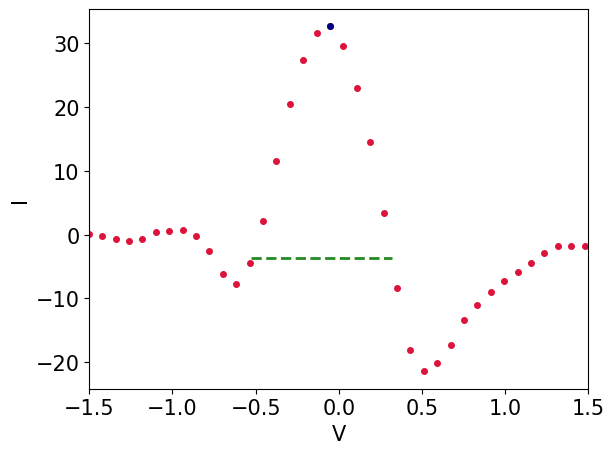

In [176]:
df = read_df('laser/rojo')[10:].reset_index()
derivada2=derivar(derivar(df.I))
derivada2=savgol(df.I,window_length=15,polyorder=3,deriv=2,delta=np.mean(np.diff(df.V_e)))

pk = fp(derivada2,height=0.5e-11,distance=10)[0][0]
widths, width_heights, left_ips, right_ips = peak_widths(derivada2,np.array([pk]),rel_height=1-1/10)
widths = index_to_xdata(df.V_e,widths)
left_ips = index_to_xdata(df.V_e,left_ips)
right_ips = index_to_xdata(df.V_e,right_ips)
    
V0 = df.V_e[pk]
err_V0 = (right_ips - left_ips)[0]/2
#print(V0)
print(err_V0)
plt.scatter(df.V_e,derivada2*1e12,c='crimson')
plt.scatter(V0,derivada2[pk]*1e12,c='navy',zorder=2,label='Pico')
plt.hlines(width_heights*1e12,left_ips,right_ips,color='forestgreen',label='Ancho',ls='--')

df = read_df('laser/rojo tint alto')[10:].reset_index()
derivada2=derivar(derivar(df.I))
derivada2=savgol(df.I,window_length=15,polyorder=3,deriv=2,delta=np.mean(np.diff(df.V_e)))
pk = fp(derivada2,height=0.5e-11,distance=10)[0][0]
widths, width_heights, left_ips, right_ips = peak_widths(derivada2,np.array([pk]),rel_height=1-1/10)
widths = index_to_xdata(df.V_e,widths)
left_ips = index_to_xdata(df.V_e,left_ips)
right_ips = index_to_xdata(df.V_e,right_ips)
    
V0 = df.V_e[pk]
err_V0 = (right_ips - left_ips)[0]/2
#print(V0)
print(err_V0)
#plt.scatter(df.V_e,derivada2*1e12,c='forestgreen')
#plt.scatter(V0,derivada2[pk]*1e12,c='navy',zorder=2,label='Pico')
#plt.hlines(width_heights*1e12,left_ips,right_ips,color='crimson',label='Ancho',ls='--') 
plt.xlabel('V')
plt.ylabel('I')
plt.xlim(-1.5,1.5)

In [187]:
lambdas[2:9]

array([480, 500, 520, 540, 560, 580, 600])

In [9]:
print(lambdas[2:9])

[480 500 520 540 560 580 600]


In [183]:
delta_nu = c*(1/lambda_i-1/lambda_d)
print(h*delta_nu[2:9]/e)
print(central_lambdas[2:9]*1e9)
#print(V0s_res)
print(err_V0s_res)

print(np.round(err_V0s_res/(h*delta_nu[2:9]/e),1))
#plt.scatter(nus_res,h*delta_nu[2:9]/e)

[0.14429492 0.11541682 0.12346529 0.121649   0.1249575  0.11896828
 0.12149185]
[472.2598877 506.1383362 521.8369141 543.0115356 563.1571045 581.5725098
 600.520813 ]
[0.13047682 0.06750504 0.18157623 0.14687302 0.1271464  0.10119609
 0.1392461 ]
[0.9 0.6 1.5 1.2 1.  0.9 1.1]


[6.35949381e-12]
0.2620582758267977


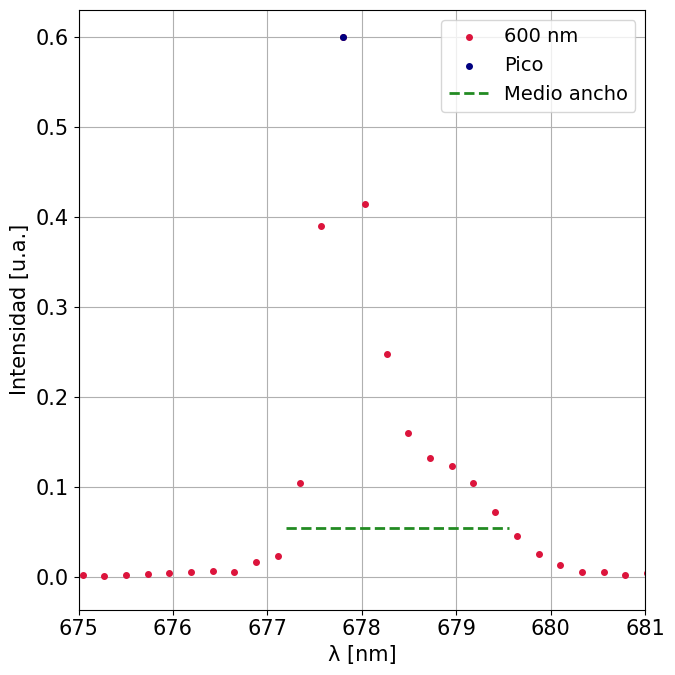

In [165]:
fig, ax = plt.subplots(figsize=(7, 7))

df = pd.read_csv(f'espectro laser rojo.csv', header=None, names=['long', 'I'])
plt.scatter(df.long, df.I,color='crimson',label=f'{long} nm')
    
pk = fp(df.I,height=0.9*np.max(df.I),distance=200)[0]
widths, width_heights, left_ips, right_ips = peak_widths(df.I,pk,rel_height=1-1/10)
widths = index_to_xdata(df.long,widths)
left_ips = index_to_xdata(df.long,left_ips)
right_ips = index_to_xdata(df.long,right_ips)

print(h*c*(1/left_ips-1/right_ips)/e)
print(err_V0)

plt.scatter(df.long[pk],df.I[pk],c='navy',zorder=2,label='Pico')
plt.hlines(width_heights,left_ips,right_ips,color='forestgreen',ls='--',label='Medio ancho')

plt.xlim(675,681)
plt.grid()
plt.xlabel('\u03BB [nm]')
plt.ylabel('Intensidad [u.a.]')
plt.legend(fontsize=14)
plt.tight_layout()